In [1]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# For kernel covariance matrix
import seaborn as sns

In [2]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#1E77B4','#FCAF38',"#BFD061", "#F95335"] #Color scheme
USGS_site_id = ['05325000','05325300','05330000']
markers = ['s', 'o','^']
labels = list(string.ascii_uppercase)
alpha_site_id = labels[0:len(USGS_site_id)]

plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS site data and SAC

In [3]:
#Load USGS data
# numbers for easy enumeration
site_numbs = np.arange(len(USGS_site_id))
# updates ADVM and grab_samples readings to included calculated SAC and SSC already and calucated dq/dt for samples
ADVM_readings = create_USGS_dfs('sensor', USGS_site_id) #Sensor readings for all sites
Grab_samples = create_USGS_dfs('samples', USGS_site_id) #Grab samples and flow for all sites
Qall_time = create_USGS_dfs('Qall', USGS_site_id) #Discharge for total time range of sensor deployment per site


dfc = pd.read_csv(r'USGS_data/USGS_site_consts.csv') # Read in constants for all sites
dfc['Site_ID'] = dfc['Site_ID'].map(toName) #Converts Site_ID to string type

data_dictionary = {} # empty dictionary to put dataframes into, keys are site id
for i, id in enumerate(USGS_site_id):
    #Selects constants for each USGS site
    Consts = dfc.loc[dfc['Site_ID'] ==  id].iloc[0, 1:]

    data_dictionary[alpha_site_id[i]] = { 'USGS_id' : id,
                            'ADVM' : ADVM_readings[id],
                            'Samples' : Grab_samples[id],
                            'Flow' : Qall_time[id],
                            'Consts' : Consts # This is a pandas series
                        }

# Functions

## Gaussian Process

In [4]:
def GP(SAC_m, SSC_m, p, SAC_range = [None,None], SAC_log=False, SSC_log=False, hyperparams = -999):
    #assuming don't want log value (and pass regular values)
    #option to pass in hyperparameters -> it is a 2 element list where the first is the rbf (squared exponentia - l) length scale, the second is the white noise level
    # Combination of RBF and whitekernel set to optimize hyperparameters
    if hyperparams == -999:
        kernel = RBF() + WhiteKernel()
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")

    # Calculate range for model run 
        #safety measure if not put in correct order and if passed as list with wiggle room
    if SAC_range != [None,None]:
        min_SAC = np.array(SAC_range).min()-(0.1*np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max()+(0.1*np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()    

    #Set variables for training
    X = np.array(SAC_m).reshape(-1,1)
    y = SSC_m #hand made for scale 2
    
    #Change to log based if output desired is in log and calucate range
    if SAC_log == True:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(np.array(SAC_m).reshape(-1,1))
    if SSC_log == True:
         y = np.log10(SSC_m) 

    #Make range for SAC prediction
    SAC_pred = np.linspace(min_SAC,max_SAC,p)

    #Create model from training data
    # https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    gaussian_proccess = GaussianProcessRegressor(kernel=kernel, normalize_y = True)
    gpr = gaussian_proccess.fit(X,y)
    gaussian_proccess.kernel_
    GP_score = gpr.score(X,y) # I don't think this means anything. because it seems like it's train x and test x??
    GP_logmarg = gpr.log_marginal_likelihood()
    
    #Make predicted model from kernel
    [Y_pred, std] = gpr.predict(SAC_pred.reshape(-1, 1) , return_std = True)

    # how to get kernel with optimized hyperparameters: gaussian_proccess.kenerl_.theta
    return (SAC_pred, Y_pred, std, GP_score, GP_logmarg, gaussian_proccess)


## Covariance matrix to correlation matrix

In [5]:
def cov_to_cor(cov):
    # get diagonal elements from covaraince matrix
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v,v)
    cor = cov/outer_v
    cor[cov == 0] = 0
    return cor

### make kernel matrix function of k(xi, xj)

In [6]:
# make my own kernel matrix function of k(xi,xj)

def rbf_ker(x,y,l):
    k = math.exp(- math.dist([x],[y]) / (2*l**2) )
    return k

# Linear fits

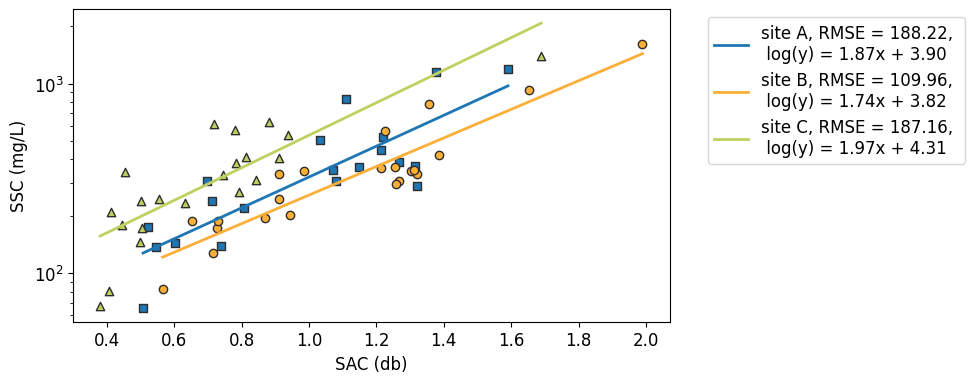

In [7]:
plt.figure(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    colr = colr_sc[i]
    mod = data_dictionary[id]['Samples']
    
    # Scatter plot
    x = np.array(mod['SAC']).reshape(-1, 1)
    y = np.array(mod['SSC']).reshape(-1, 1)
    plt.scatter(x, y, color=colr, marker=markers[i], edgecolors='#2E2E2E', zorder=1)
    
    # Use log of y for linear regression
    log_y = np.log(y)
    
    # Linear regression
    model = LinearRegression()
    model.fit(x, log_y)
    log_y_pred = model.predict(x)
    
    # Sort the data for plotting
    sorted_indices = np.argsort(x.ravel())
    x_sorted = x[sorted_indices]
    log_y_pred_sorted = log_y_pred[sorted_indices]
    
    # Calculate the slope and intercept
    slope = model.coef_[0, 0]
    intercept = model.intercept_[0]
    
    # Calculate RMSE using log values
    log_rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(np.exp(log_y), np.exp(log_y_pred)))
    
    # Plot the fitted line in the original scale
    plt.plot(x_sorted, np.exp(log_y_pred_sorted), linewidth=2, color=colr, 
             label=f'site {id}, RMSE = {rmse:.2f}, \n log(y) = {slope:.2f}x + {intercept:.2f}')

plt.yscale('log')
plt.xlabel('SAC (db)')
plt.ylabel('SSC (mg/L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/linear_fit.png' , dpi=500) 

plt.show()



# Gaussian baseline models

## uses all grabs samples at given site to train a model for that site

A: l = 0.57, nl = 0.51
B: l = 0.41, nl = 0.12
C: l = 0.58, nl = 0.18


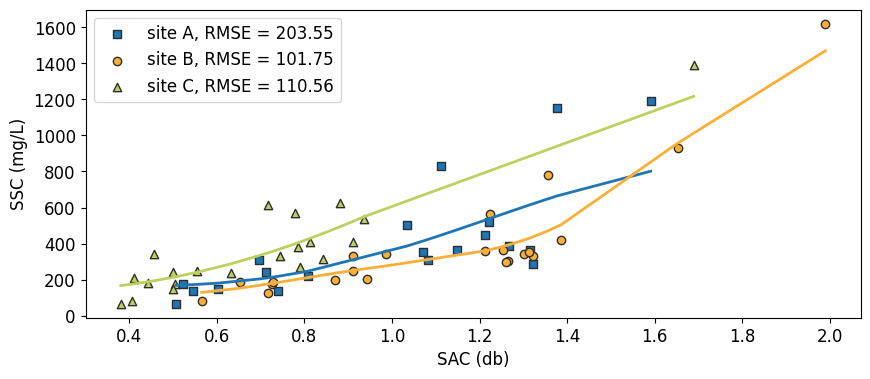

In [8]:
model_dictionary = {}

plt.figure(figsize=(10, 4))


#Run GP using all data
# for by site, optimizing hyperparameters -> stored by USGS site name
for i, id in enumerate(alpha_site_id):
    site_data = data_dictionary[id]
    xdata = site_data['Samples']['SAC'].to_numpy()
    ydata = site_data['Samples']['SSC'].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model = GP(xdata, ydata, p)  
    # obtains length scales of rbf and noise level for white kernel from trained GP model
    l,nw = np.exp(GP_model.kernel_.theta)
    print(f'{id}: l = {np.round(l,2)}, nl = {np.round(nw,2)}')
    # important ypred and ydata are sorted same order wrt xdata
    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True, return_cov=False)
    MSE_all = np.square(np.subtract(ydata,ypred)).mean() 
    rmse_all = math.sqrt(MSE_all)

    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))

    # Sort xdata and reorder ypred to match
    sorted_indices = np.argsort(xdata)
    x_sorted = np.array(xdata)[sorted_indices]
    y_sorted = np.array(ypred)[sorted_indices]
    std_sorted = np.array(std_pred)[sorted_indices]

    plt.scatter(xdata, ydata, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', zorder=1, label=f'site {id}, RMSE = {rmse_all:.2f}')
    plt.plot(x_sorted, y_sorted, color=colr_sc[i], linewidth=2)   
    # plt.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, color=colr_sc[i], alpha=0.2)

    plt.xlabel('SAC (db)')
    plt.ylabel('SSC (mg/L)')
    plt.legend()
    # plt.savefig(f'figures/GP_baselinemodel.png', dpi=500)

    model_dictionary[id] = {    'hyperparams': {
                                    'rbf_l' : l,
                                    'noise_l' : nw,
                                },
                                'x': xdata,
                                'y': ydata,
                                'n_pred': ypred,
                                'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
                                # 'scores': [GP_score_all, GP_logmarg_all, r_score_all, rmse_all],
                                'scores': {
                                    'GP_score':GP_score_all, 
                                    'GP_logmarg':GP_logmarg_all,
                                    'r_score': r_score_all, 
                                    'rmse' : rmse_all, 
                                    'std': std_pred
                                },
                                'model': GP_model
                                }
    
plt.show()


## All kernels on all sites permutations

In [9]:
# Initialize the new dictionary
cross_prediction_dictionary = {site_id: {} for site_id in alpha_site_id}

# Loop through each combination of test and model sites
for model_id in alpha_site_id:
    for site_id in alpha_site_id:
        # Get the model from the model_dictionary
        GP_model = model_dictionary[model_id]['model']

        # Get the test site data
        test_data = data_dictionary[site_id]
        x_test = test_data['Samples']['SAC'].to_numpy()
        y_test = test_data['Samples']['SSC'].to_numpy()

        # Use the model to predict SSC for the test data
        y_pred, std_pred = GP_model.predict(x_test.reshape(-1, 1), return_std=True)

        # Calculate scores
        MSE = np.square(np.subtract(y_test, y_pred)).mean()
        rmse = math.sqrt(MSE)
        r_score = GP_model.score(y_pred.reshape(-1, 1), y_test.reshape(-1, 1))

        # Store the results in the new dictionary
        cross_prediction_dictionary[site_id][model_id] = {
            'hyperparams': {
                'rbf_l' : l,
                'noise_l' : nw,
            },
            'x': xdata,
            'y': ydata,
            'n_pred': ypred,
            'scores': {
                'r_score': r_score, 
                'rmse' : rmse, 
                'std': std_pred
            },
            'model': GP_model
                                           
        }

In [10]:

print("RMSE for all sites with different models used to predict on it:")

for site_id in alpha_site_id:
    print(f"\nTest Site: {site_id}")
    # base_r, base_rmse = model_dictionary[site_id]['scores'][2:4]
    # print(f"  Baseline from Site {site_id}: RMSE = {base_rmse:.2f}; R = {base_r:.2f}")

    for i, model_id in enumerate(alpha_site_id):
        rmse = cross_prediction_dictionary[site_id][model_id]['scores']['rmse']
        r = cross_prediction_dictionary[site_id][model_id]['scores']['r_score']
        print(f"  Model from Site {model_id}: RMSE = {rmse:.2f}")


RMSE for all sites with different models used to predict on it:

Test Site: A
  Model from Site A: RMSE = 203.55
  Model from Site B: RMSE = 219.78
  Model from Site C: RMSE = 320.21

Test Site: B
  Model from Site A: RMSE = 232.50
  Model from Site B: RMSE = 101.75
  Model from Site C: RMSE = 415.51

Test Site: C
  Model from Site A: RMSE = 205.14
  Model from Site B: RMSE = 209.48
  Model from Site C: RMSE = 110.56


# optimal sample selection

## Creating the covariance matrix for each site

### Compute matrix for each site, specifiying n points

In [11]:
# Initialize the dictionary to store results
correlation_matrices = {}
n_range = [20, 25, 50, 100]  # Number of points for covariance matrix

# Loop through all sites using alpha_site_id
for id in alpha_site_id:
    # initialize dictionary for site
    correlation_matrices[id] = {}
    # Read in values from the past dictionaries
    mod = model_dictionary[id]
    x = mod['x']
    y = mod['y']
    pred_x = mod['p_pred'][0]
    pred_y = mod['p_pred'][1]
    rmse = mod['scores']
    l = mod['hyperparams']['rbf_l']
    nw = mod['hyperparams']['noise_l']

    # Sort data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    ''' 
    For n point range
    '''
    correlation_matrices[id]['n'] = {}
    for n in n_range: 
        # Make evenly spaced array of length n to predict the model with
        nx_trend = np.linspace(np.min(x_sort) - 0.05, np.max(x_sort) + 0.5, n)

        # Initialize the RBF kernel matrix
        rbf = np.zeros((n, n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(nx_trend):
            for j, y in enumerate(nx_trend):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['n'][n] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range' : nx_trend,
        }

    ''' 
    For num samples range across all sites 
    '''
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:        
        # Still using the target site readings
        samp_n = len(x_sort)

        # grab the length scales for the model site
        ker = model_dictionary[model_id]['hyperparams']
        l = ker['rbf_l']
        nw = ker['noise_l']
        # Initialize the RBF kernel matrix
        rbf = np.zeros((samp_n, samp_n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(x_sort):
            for j, y in enumerate(x_sort):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(samp_n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['num_samp'][model_id] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range': x_sort,
                'n' : samp_n,
        }

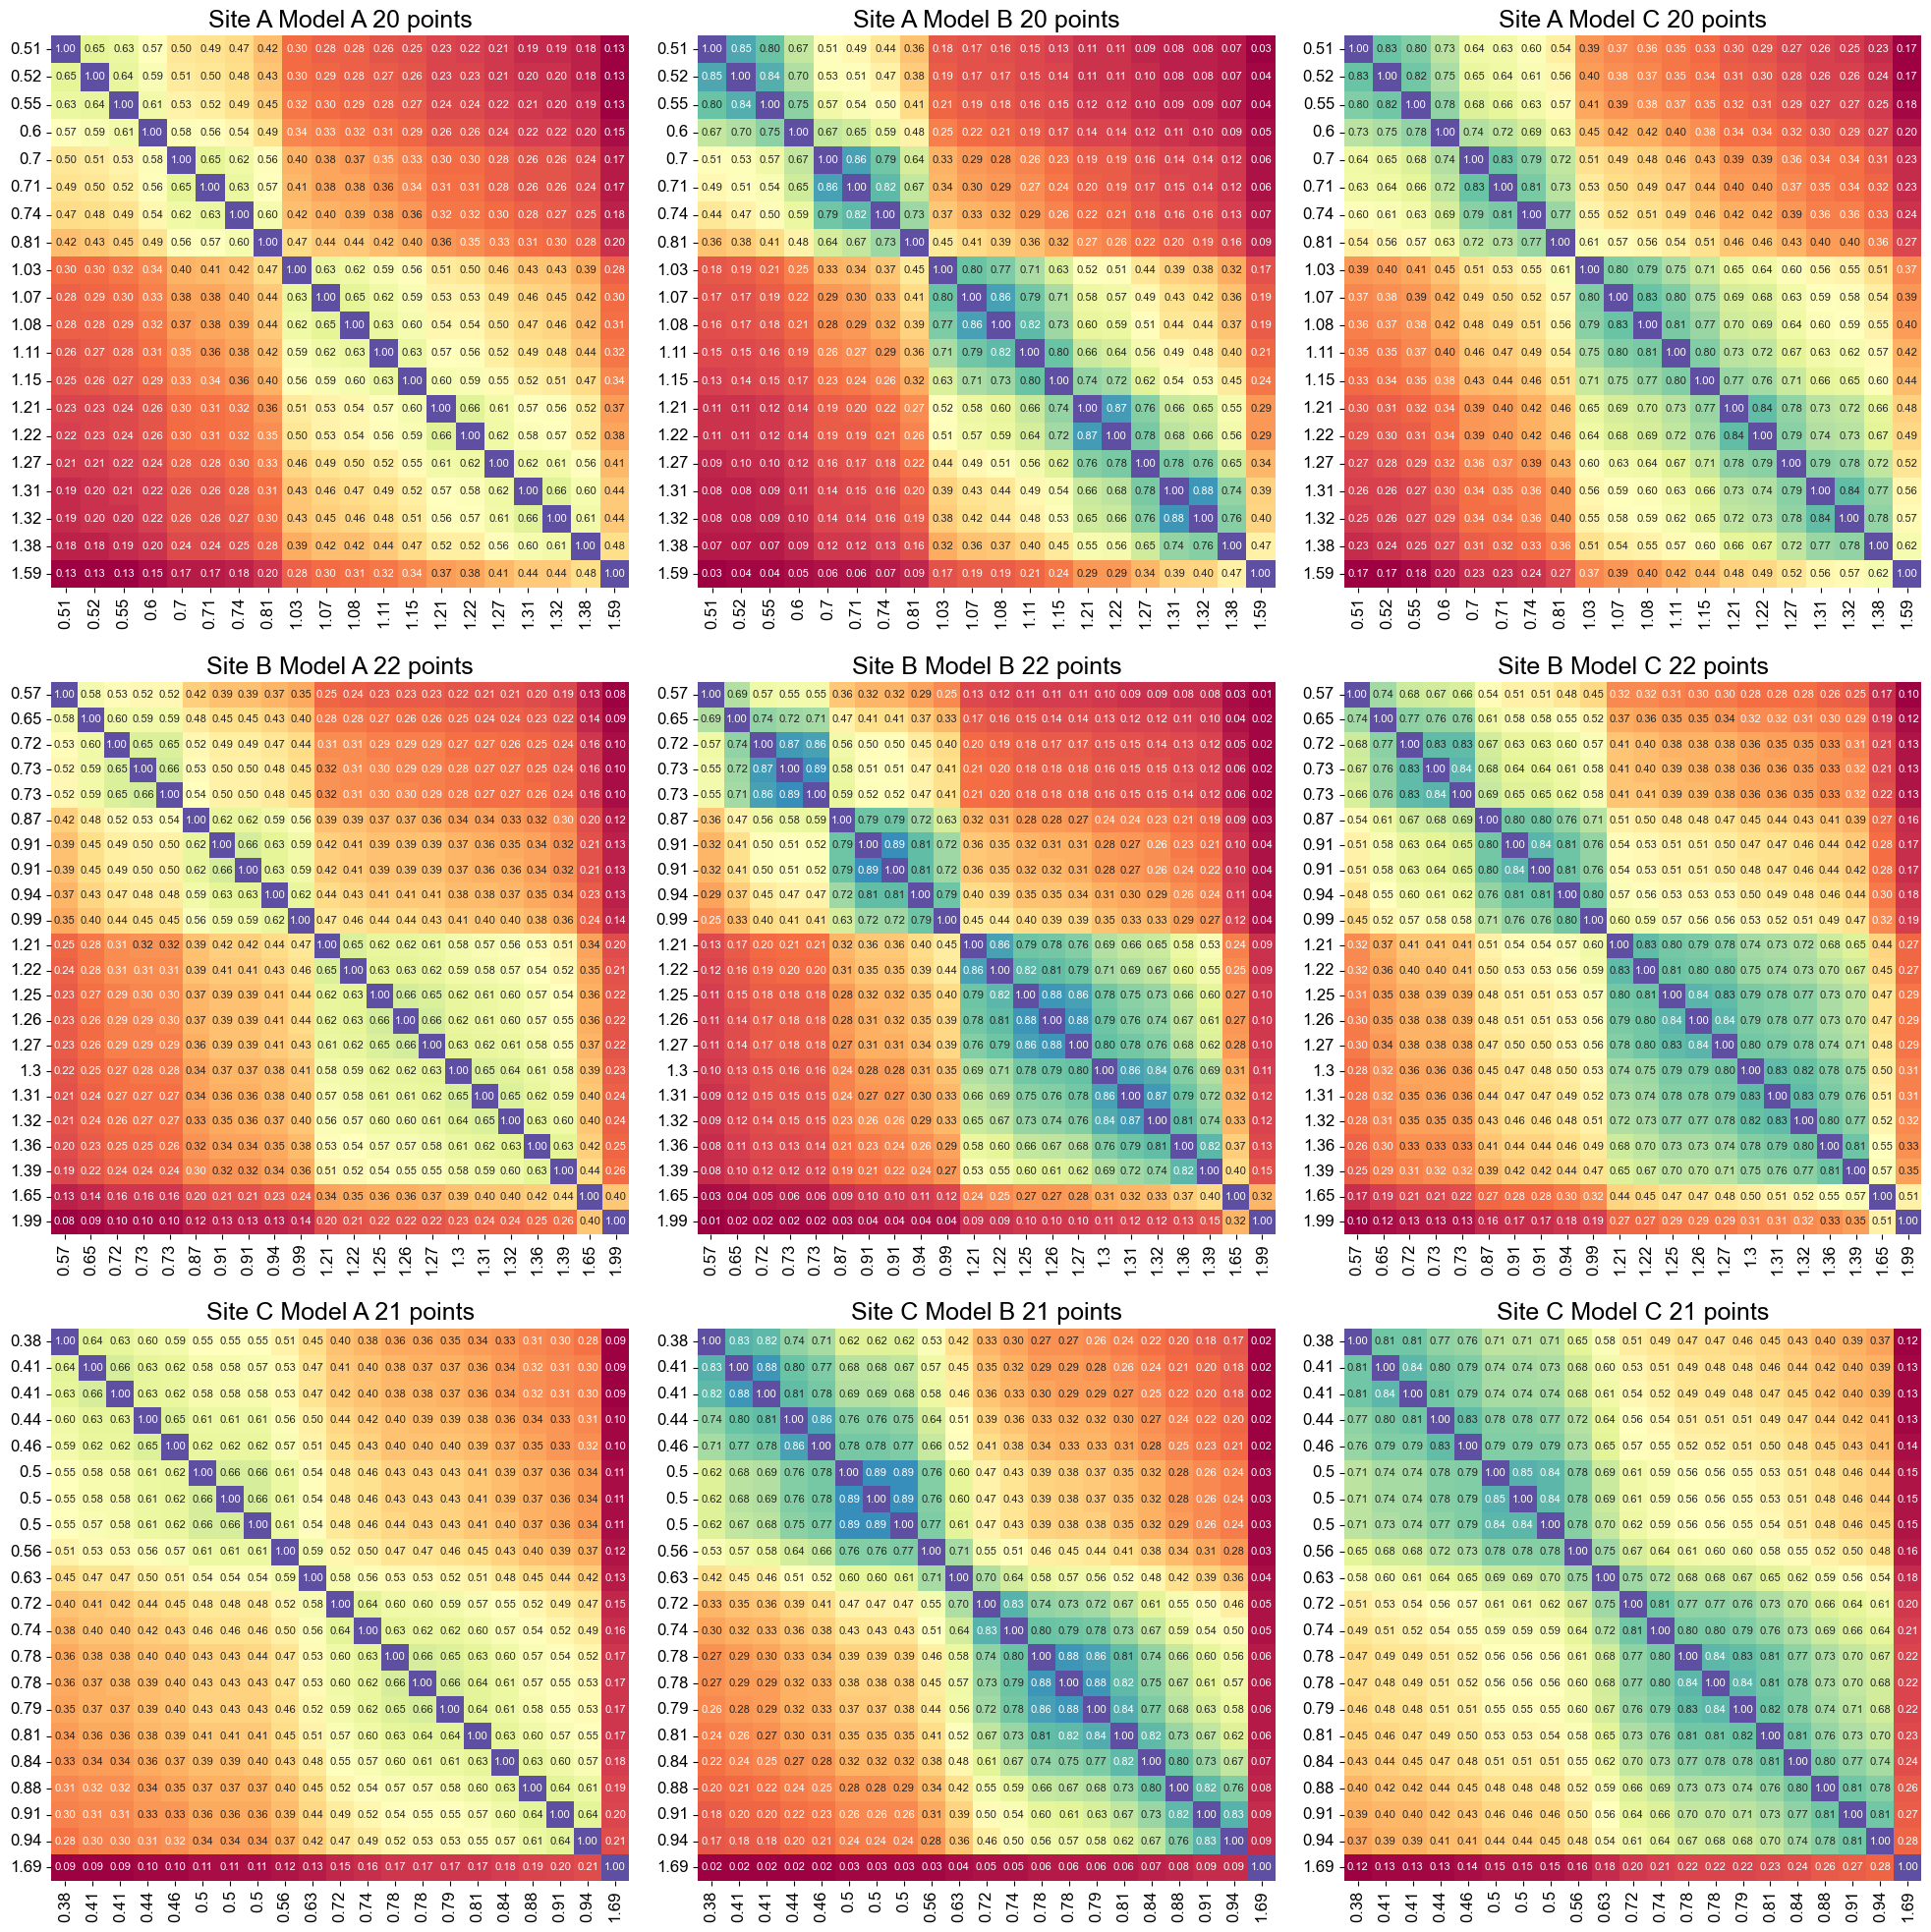

In [12]:
# Plotting the correlation matrices in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

index = 0
for id, models in correlation_matrices.items():
    for model_id, data in models['num_samp'].items():
        if index >= len(axes):
            break
        
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        mask_lt = np.triu(np.ones(cor_mat.shape), k=1).astype(bool)

        sns.set(font_scale=1.5)
        sns.heatmap(
            np.round(cor_mat, 2),
            # mask=mask_lt,
            cbar=False,
            annot=True,
            # square=True,
            cmap="Spectral",
            fmt='.2f',
            annot_kws={'size': 8},
            yticklabels=np.round(np.sort(nx_trend), 2),
            xticklabels=np.round(np.sort(nx_trend), 2),
            ax=axes[index]
        )
        axes[index].set_title(f'Site {id} Model {model_id} {len(nx_trend)} points')
        index += 1

# Hide any unused subplots
for j in range(index, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### save to ".mat" to use in matlab

In [13]:
# But really only care for the at site A, ker B and C
# import os

MATLAB_filepath = "GVR_data_code"
# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    for model_id, data in models['num_samp'].items():
        print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_filepath}/SAC_samp{id}.mat', {'SAC': nx_trend})
    
    
    # save n samples too
    for n, data in models['n'].items():
        print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        scipy.io.savemat(f'{MATLAB_filepath}/SAC_range{id}{n}.mat', {'SAC': nx_trend})

# scipy.io.savemat(f'corr_samp{model_id}.mat', {'cor_mat': cor_mat})
# scipy.io.savemat(f'SAC_samp{id}.mat', {'SAC': x_sort})

data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100
data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100
data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100


## Matlab results

In [14]:
# mat_file = scipy.io.loadmat('GVR_data_code/rangeA25.mat')
# print(mat_file['A'][0])
# print(mat_file['scores'][0])

""" read sample selection and scores given arbritrary SAC range """
range_selection = {}

for id in alpha_site_id:
    range_selection[id] = {}
    for n in n_range:
        range_selection[id][n] = {}
        dict = range_selection[id][n]
        mat_file = scipy.io.loadmat(f'GVR_data_code/range{id}{n}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'GVR_data_code/samp{id}{model_id}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]


## Plot elbow curves

### Plot for generic range

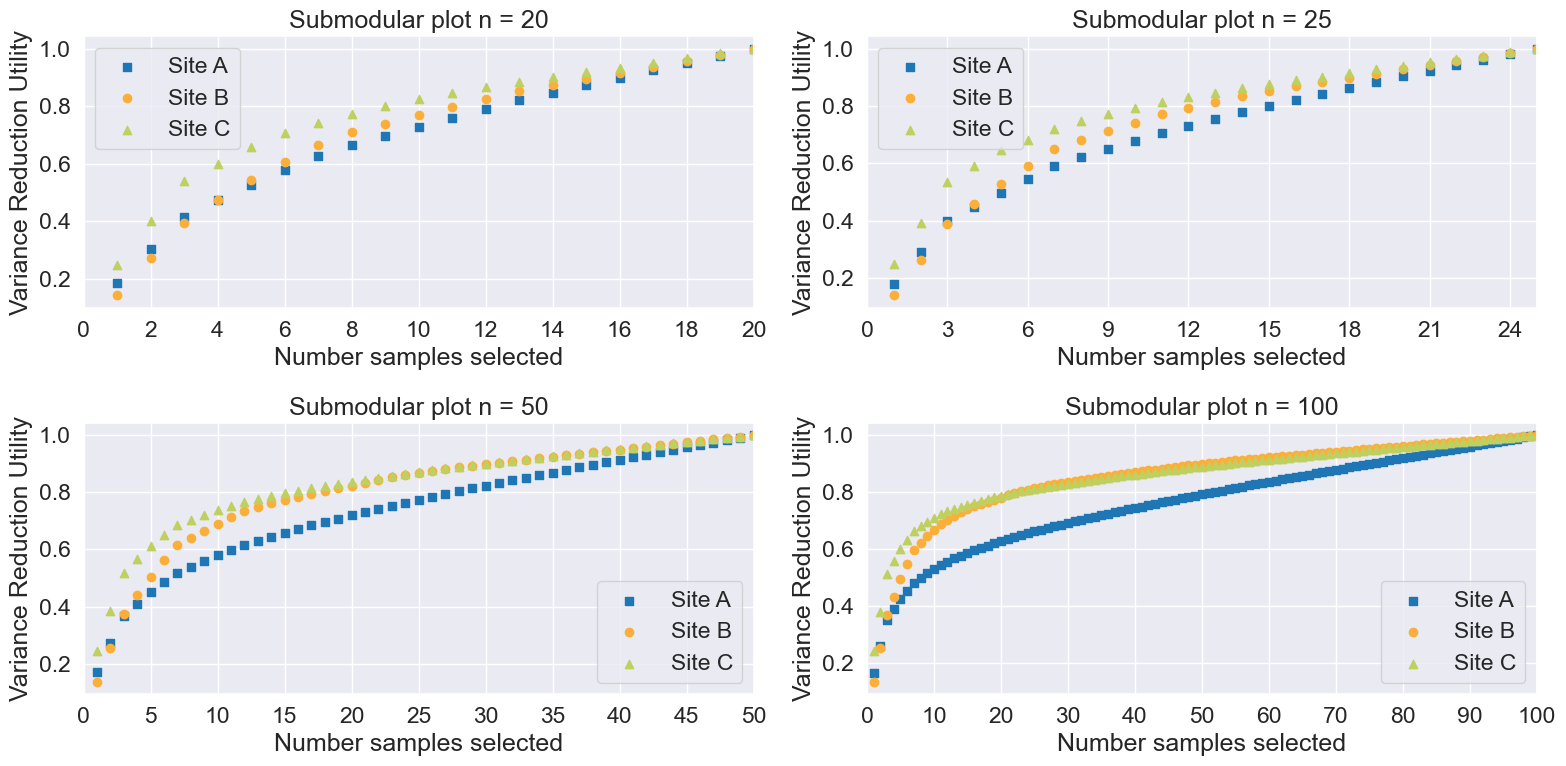

In [15]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

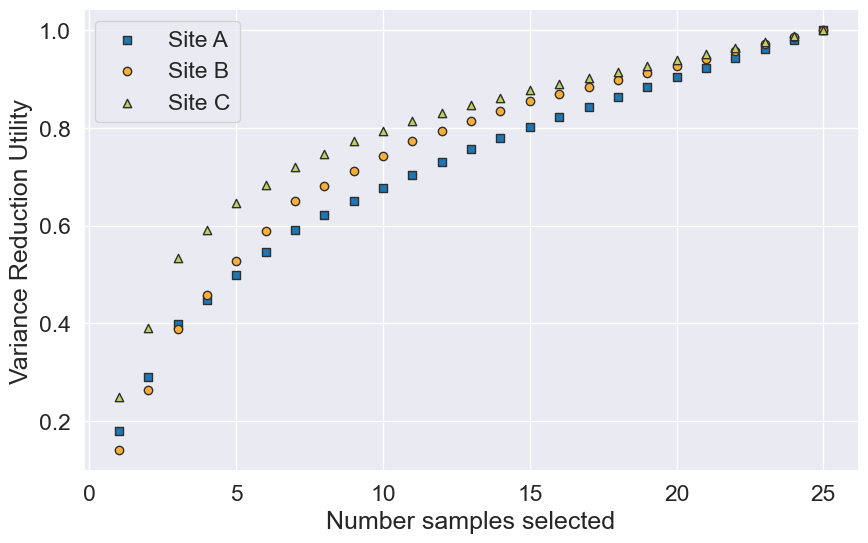

In [16]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 6))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

### Plot for kernel permutation

A C plotted
B C plotted
C C plotted


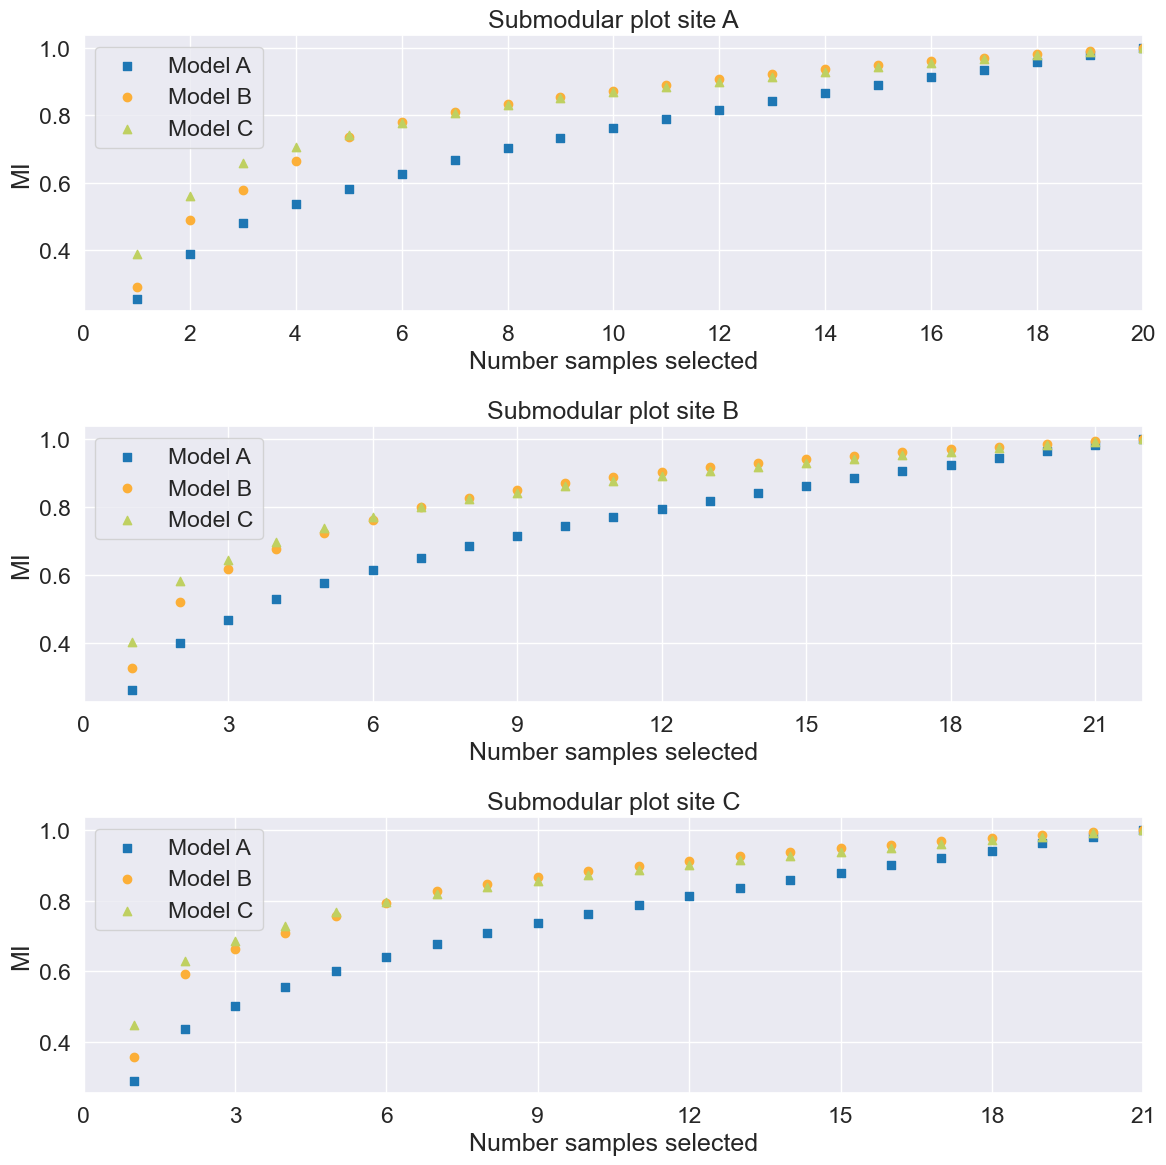

In [17]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error plots

## Calculating for optimal selection

### Start at 2 samples to train model, increase to 15, always test with remaining amount

In [18]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[11  3 17  6 19  0 13  8  7 18  2 10  4 15 12  1 16  5  9 14]
[13  4  1  9 17 19  7 12  3 18  8  6 15  0 11  2  5 14 16 10]
[11  3 17  6 19  0 14  8  7 18  4  2 10 15 12  1  5 13 16  9]
[13  3  7 18 21  0 10 20  9 16  1  5 19  2 12  8 15 11  4  6 17 14]
[14  3  7 18 21  0 20 10  9 16  1  5 19  8 12  2 15 11 17  4  6 13]
[13  3  7 20 17 21  0  9 19 10  1  5 15  2  8 11 18 14  4  6 16 12]
[12  4 18  7 20  0 10 16  8 19  2  9 14  5 17 11  1 15  3  6 13]
[13  4 18 20  7  1  9 10 16  8  0 19 15 11 17  5  3 12  2 14  6]
[12  4 18 20  7  0 10 16  9  2 19  8 14  5 17 11  3 15  1  6 13]


In [19]:
all_data = model_dictionary[site_id]
all_x = all_data['x']
all_y = all_data['y']

baseline_rmse = all_data['scores']['rmse']

In [ ]:
optimal_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]

        opt_select = {
                        'opt_order' : opt_select['samples']
                    }

        opt_samp = opt_select['opt_order']
        print(f'length of samples: {len(opt_samp)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}
        # -4 will leave 5 test samples
        for n in np.arange(2,len(opt_samp)-4):
            opt_x = all_x_sort[opt_samp[0:n]]
            opt_y = all_y_sort[opt_samp[0:n]]
            test_x = all_x_sort[opt_samp[n:]]
            test_y = all_y_sort[opt_samp[n:]]
            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model = GP(opt_x, opt_y, p) 
            l_opt,nw_opt = np.exp(GP_model.kernel_.theta)

            # important ypred and ydata are sorted same order wrt xdata
            ypred, std_pred = GP_model.predict(test_x.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {  'hyperparams': {
                                                                'rbf_l' : l_opt,
                                                                'noise_l' : nw_opt,
                                                            },
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'x_test' : test_x,
                                                            'y_test' : test_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

## Calculating for random

In [21]:
# modified function from GP_funcs.py so don't have to deal with passing in date time and Q

# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model = ([None] * r for i in range(10))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model)

In [ ]:
# now we're going to make a dictionary of the different trials with different number of points
r = 20
#generalize for all sites
# sample_size = np.arange(1,21)
# sample_size = [5,10,8]
# id = 1

random_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    random_dictionary[site_id] = {}
    
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]

    random_dictionary[site_id] = {  'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_all' : all_x,
                                    'y_all' : all_y,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_samples' : len(all_x_sort)
                                }
    
    num_samp = random_dictionary[site_id]['num_samples']
    # start with using 2 samples
    sample_size = np.arange(2,num_samp+1-5)
    
    for n in sample_size:
        SAC_r, SSC_r, ind_r, SAC_pred_r, SSC_pred_r, std_r, GP_score_r, GP_logmarg_r, GP_model_r = random_samp_models(r, n, all_x, all_y)

        #initalize list to hold all ypred for given number of samples 
        ypred_r = ([None] * r) 
        rmse_r = ([None] * r) 
        l_rand = ([None] * r) 
        nw_rand = ([None] * r) 
        std_pred_r = ([None] * r) 
        r_score_r = ([None] * r) 

        # make prediction for all data points using model and calculate rmse
        for i in range(r):
            x_train = all_x[ind_r[i]]
            y_train = all_y[ind_r[i]]
            x_test =  np.delete(all_x,ind_r[i]) 
            # print(x_test)
            y_test = np.delete(all_y,ind_r[i]) 
            ypred_r[i], std_pred_r = GP_model_r[i].predict(x_test.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_r = np.square(np.subtract(y_test,ypred_r[i])).mean()     
            rmse_r[i] = math.sqrt(MSE_r) 
            l_rand[i],nw_rand[i] = np.exp(GP_model_r[i].kernel_.theta)

            r_score_r[i] = GP_model.score(ypred_r[i].reshape(-1, 1),y_test.reshape(-1, 1))
        rmse_r = np.asarray(rmse_r)
        r_score_r = np.asarray(r_score_r)

        print(type(n))

        random_dictionary[site_id][n] = {   'hyperparams': {
                                                'rbf_l' : l_rand,
                                                'noise_l' : nw_rand,
                                            },
                                            'xdata' : SAC_r,
                                            'ydata' : SSC_r,
                                            'indicies' : ind_r,
                                            'n_pred' : ypred_r,
                                            'p_pred' : [SAC_pred_r, SSC_pred_r, std_r],
                                            'score' : {
                                                'GP_score' : GP_score_r,
                                                'GP_logmarg' : GP_logmarg_r,
                                               'r_score': r_score_r, 
                                                'rmse' : rmse_r, 
                                                'std': std_pred_r,
                                            },
                                            'model' : GP_model_r,
                                            'rmse_mean' : rmse_r.mean(),
                                            'rmse_std' : rmse_r.std(),
                                            'rmse_best' : [rmse_r.min(), rmse_r.argmin()],
                                            'rmse_worst' : [rmse_r.max(), rmse_r.argmax()]
                                        }



[309.76486605271367, 264.18500818413634, 198.63845185110324, 209.113254501411, 200.10398156248684, 188.9273923811347, 194.4171620294676, 182.2008981687908, 120.72520940762777, 172.44341811873494, 100.02801641896143, 99.97816857332394, 98.48897940938576, 92.9829751971599]
[314.2850395417983, 215.22721094758037, 119.32396467376705, 131.34313532942642, 116.79681885690395, 114.96283292685848, 103.82939866251581, 111.4468960289118, 84.14764216618659, 108.93892236738603, 78.94300731242448, 73.47442533258054, 79.500916257723, 64.27616501280548, 55.68300813415121, 54.745925893741685]
[282.0546643012487, 271.024845007925, 259.26122997455053, 107.94844328514283, 170.00633430986693, 121.9598092821169, 119.46283300604355, 104.3381755063786, 93.74559556402636, 105.78055777427431, 75.08627492503838, 80.85774694867222, 84.65194731857133, 77.81936416514392, 95.32270352410251]


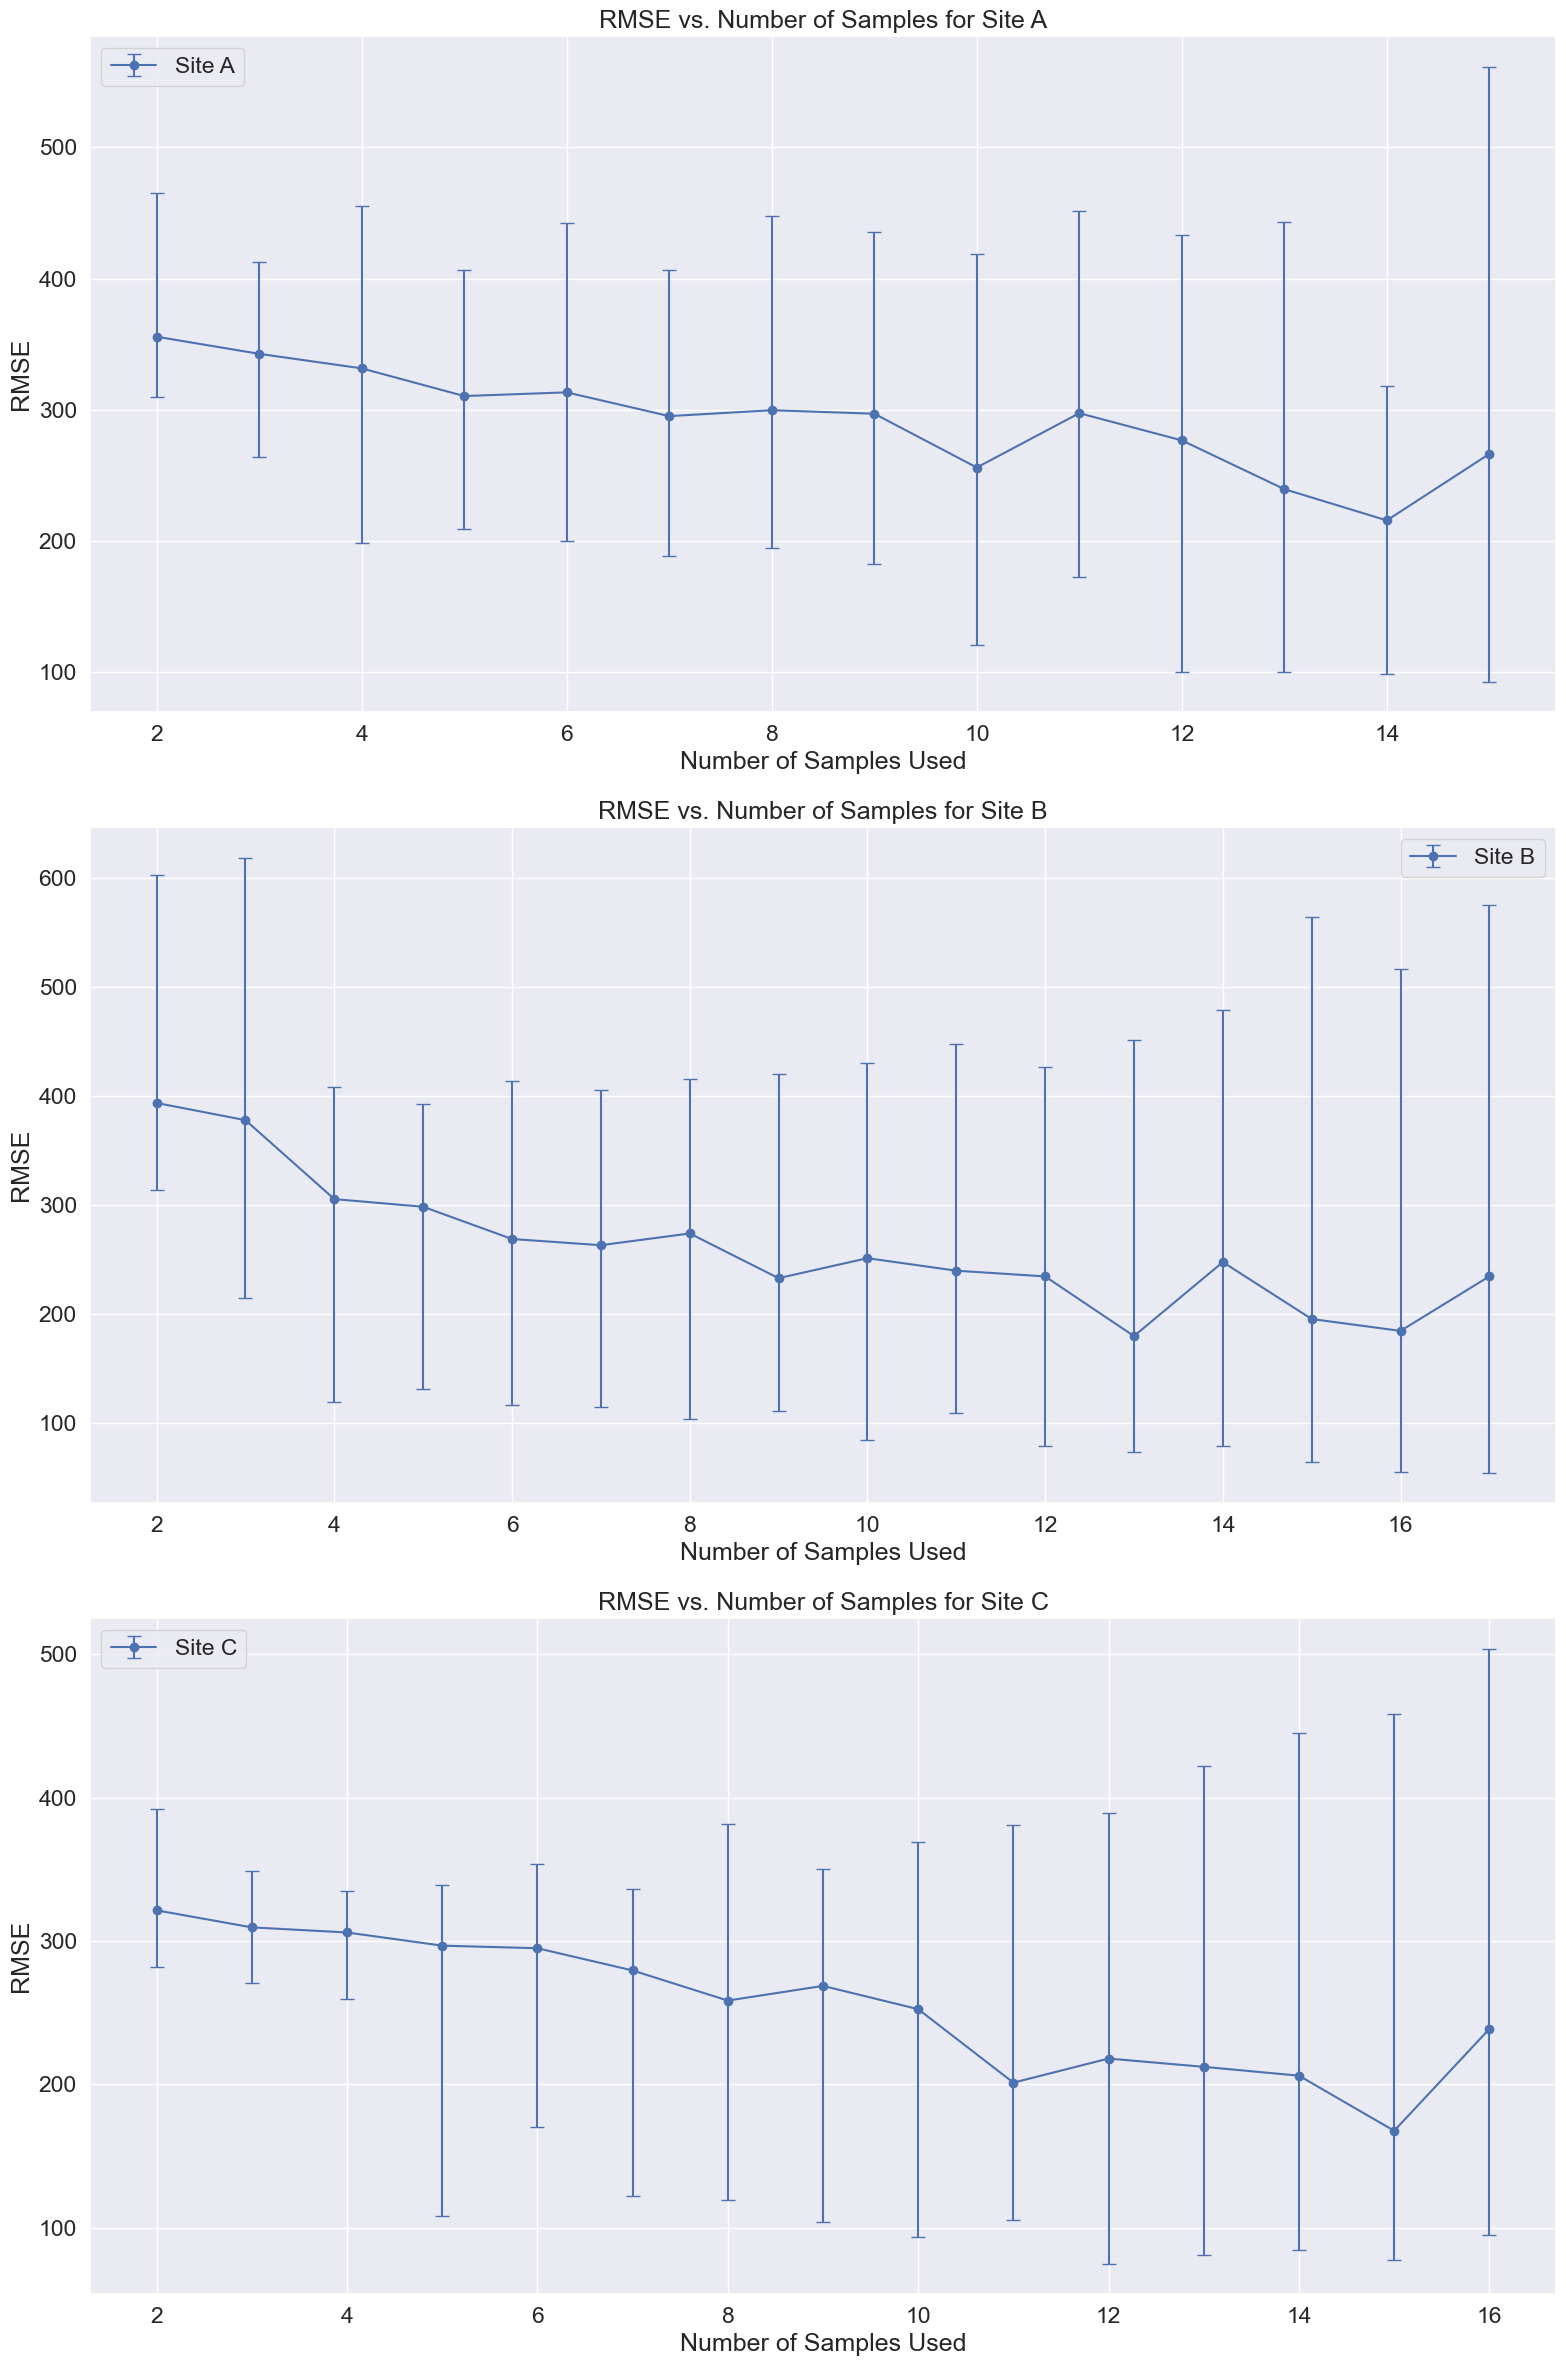

In [23]:
# Plotting the curves with subplots for each site in random_dictionary
fig, axes = plt.subplots(3, 1, figsize=(16, 24))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    print(rmse_mins)
    ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                fmt='-o', capsize=5, label=f'Site {site_id}')
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE vs. Number of Samples for Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide any unused subplots if random_dictionary has less than 3 sites
for i in range(len(random_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.show()



## Plot all together with baseline. Random bars are max and min values

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


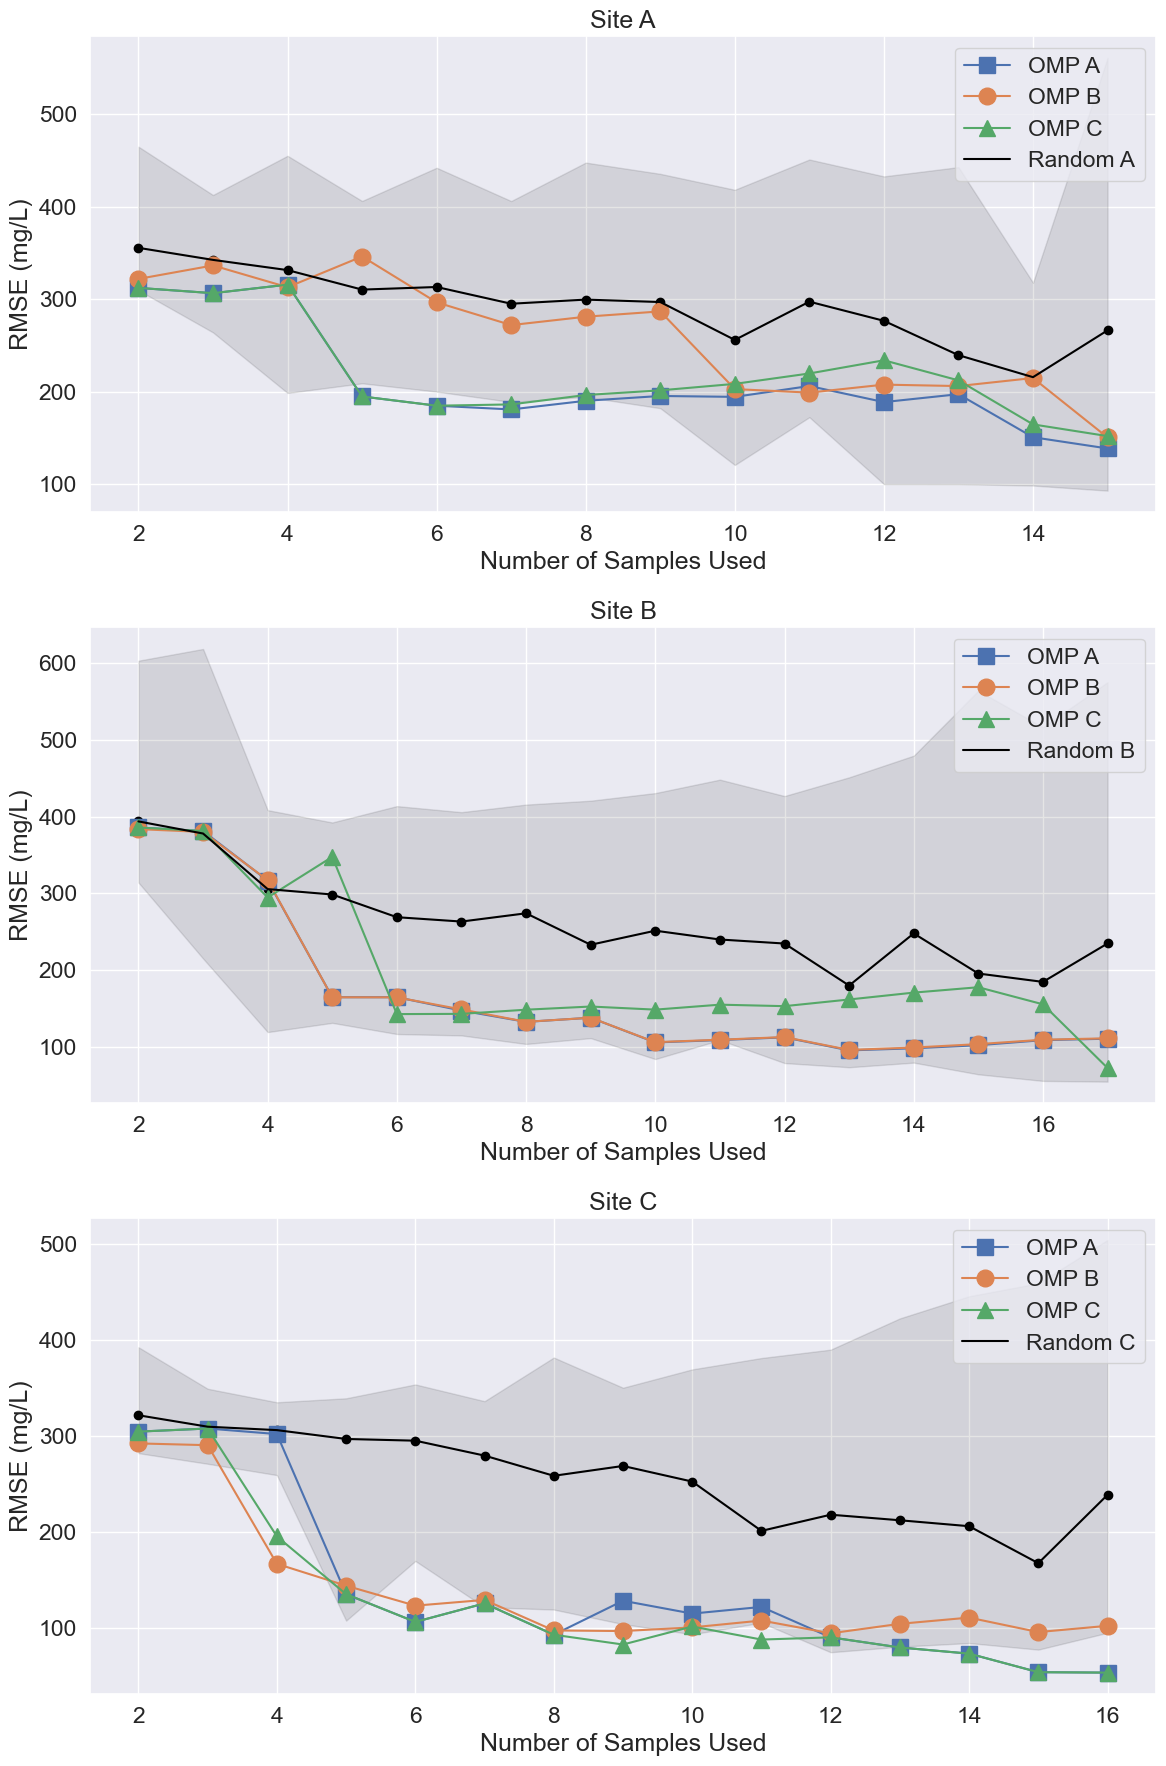

In [24]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



# Time series prediction

[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[337.07773362 337.07773362 337.07773362 ... 337.07773362 337.07773362
 337.07773362]
[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[220.41289518 220.71449508 221.31591867 ... 219.08295989 219.1272206
 219.05486615]
[220.08681885 220.36834338 220.93448412 ... 218.91151923 218.94172113
 218.89828903]
[12.19238604 11.60230378 10.94175832 ... 18.82734282 18.25680915
 19.36272954]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]
[172.68543501 173.87797958 169.23740998 ... 153.55054155 154.38923506
 153.79467824]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]


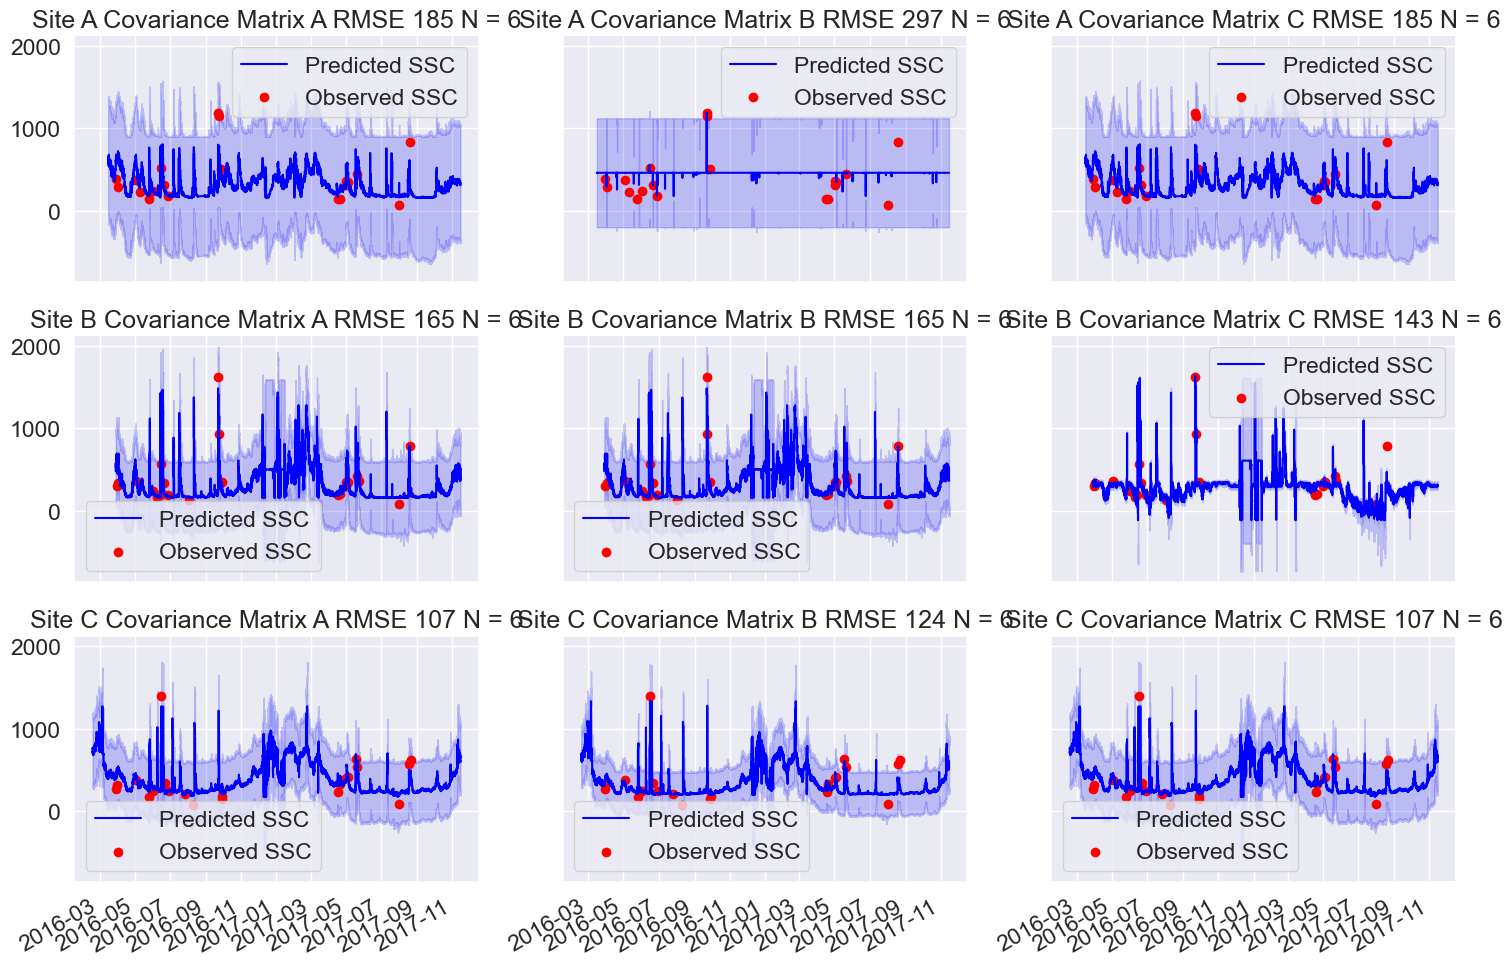

In [25]:
# Set up the 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# number samples to use for optimal training
n = 6
# Predict SSC using SAC data from `site_data[ADVM]`
plot_index = 0
for site_id in alpha_site_id:
    for i, cov_id in enumerate(alpha_site_id):
        # site_id = USGS_site_id[id]
        site_data = data_dictionary[site_id]
        advm_data = site_data['ADVM']
        sac_data = advm_data['SAC'].to_numpy()
        datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
        datetime_data = serialTimeToDatetime(datetime_num_data)


        # Use the GP model to predict SSC. This is the GP generated using covariance matrix of a site to select samples of another
        
        GP_model = optimal_dictionary[site_id][cov_id][n]['model']
        rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
        ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)
        print(ssc_std)
        # Plot the predictions
        ax = axes[plot_index]
        ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
        ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)
        
        # Match the sizes of x and y for observed data
        valid_indices = ~np.isnan(site_data['Samples']['SSC'])
        observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
        observed_dates = serialTimeToDatetime(observed_num_dates)
        observed_ssc = site_data['Samples']['SSC'][valid_indices]
        
        ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC')
        ax.set_title(f'Site {site_id} Covariance Matrix {cov_id} RMSE {rmse_opt:.0f} N = {n}')
        ax.legend()

        plot_index += 1

fig.tight_layout()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


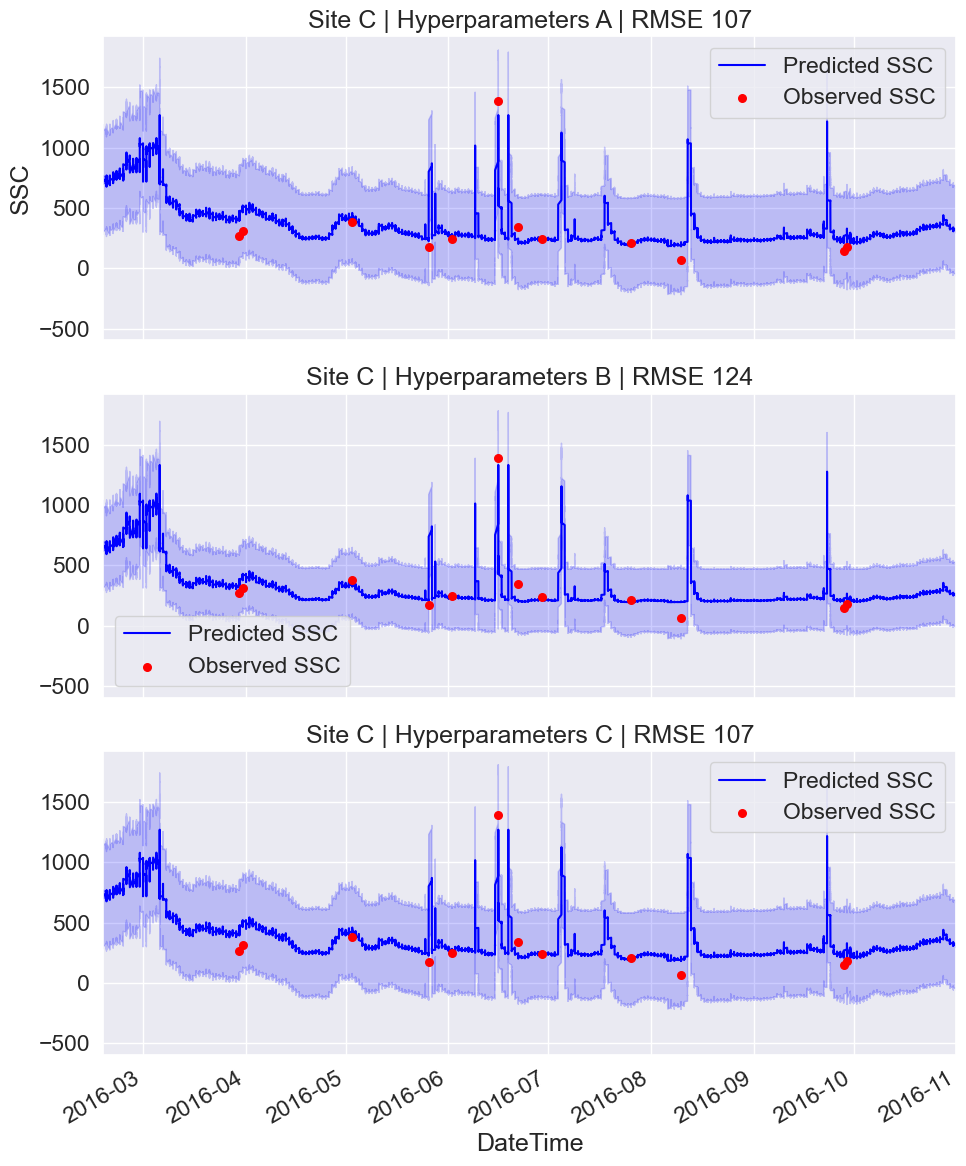

In [26]:
# Only one column for Site C with different covariance matrices
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):  # In case there's only one subplot
    axes = [axes]

site_id = 'C'  # Fix to only Site C
n = 6  # Number of samples for optimal training

# Loop over different kernel covariance matrices (cov_id = A, B, C, etc.)
for i, cov_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]
    advm_data = site_data['ADVM']
    sac_data = advm_data['SAC'].to_numpy()
    datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
    datetime_data = serialTimeToDatetime(datetime_num_data)
    
    # GP model trained with samples from cov_id applied to Site C
    GP_model = optimal_dictionary[site_id][cov_id][n]['model']
    rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
    ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)

    # Plotting
    ax = axes[i]
    ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
    ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)

    # Observed data
    valid_indices = ~np.isnan(site_data['Samples']['SSC'])
    observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
    observed_dates = serialTimeToDatetime(observed_num_dates)
    observed_ssc = site_data['Samples']['SSC'][valid_indices]
    ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC', s=30, zorder=10)

    ax.set_title(f'Site {site_id} | Hyperparameters {cov_id} | RMSE {rmse_opt:.0f}')
    ax.legend()
    ax.set_xlabel("DateTime")
    if i == 0:
        ax.set_ylabel("SSC")


# Set x-axis limit to the November 2016
date_cutoff = datetime(2016, 11, 1)
ax.set_xlim([datetime_data[0], date_cutoff])
fig.autofmt_xdate()
fig.tight_layout()
# plt.savefig('figures/Site3_SSC.png', dpi=500)
plt.show()
